In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pickle
from dateutil.relativedelta import relativedelta

In [3]:
#Read the different tables
trans = pd.read_csv("data_berka/trans.asc",sep=";")
client = pd.read_csv("data_berka/client.asc",sep=";")
account = pd.read_csv("data_berka/account.asc",sep=";")
disp = pd.read_csv("data_berka/disp.asc",sep=";")
order = pd.read_csv("data_berka/order.asc",sep=";")
loan = pd.read_csv("data_berka/loan.asc",sep=";")
card = pd.read_csv("data_berka/card.asc",sep=";")
district = pd.read_csv("data_berka/district.asc",sep=";")
print ("trans",len(trans))
print ("clients", len(client))
print ("loans", len(loan))
print ("accounts", len(account))
print ("disposition to account", len(disp))
print ("cards", len(card))
print ("orders", len(order))
print ("districts", len(district))

trans 1056320
clients 5369
loans 682
accounts 4500
disposition to account 5369
cards 892
orders 6471
districts 77


/home/dch/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
import compute_transac_stats as cts
trans2 = cts.map_columns(trans)

ModuleNotFoundError: No module named 'ipdb'

Merge the different tables
=====================

the goal is to use the information about the granted loans to train a classifier in order to predict how probably is that one loan is successful based on the client records and the information in the transaction table.

The first step is combine the diferent tables into a single one with the necessary information, modify some columns and compute new features with the information available.

In [5]:
df_allinfo = pd.merge(account,loan,on="account_id", suffixes=["_acco","_loan"], how="outer")
df_allinfo = pd.merge(disp, df_allinfo, on="account_id", how="outer")
df_allinfo = pd.merge(client, df_allinfo, on="client_id", how="outer", suffixes = ["_acco","_clie"])
df_allinfo = pd.merge(district, df_allinfo, left_on="A1", right_on="district_id_clie", how="outer")
df_allinfo = pd.merge(card, df_allinfo, on="disp_id", how="outer",suffixes=["_card", ""])

#create new columns
# convert the date to datetime instances
format_str = '%y%m%d'
mask = ~(df_allinfo["date_loan"].isna())
df_allinfo["date2_loan"] = [datetime.datetime.strptime(str(int(e)), format_str) if pd.notnull(e) else np.nan\
                for e in df_allinfo["date_loan"]]
# Set has_loan. Only those with type of disposition == Owner have loans
df_allinfo["has_loan"] = 0
df_allinfo.loc[(~df_allinfo["loan_id"].isna()) & (df_allinfo.type == "OWNER"),"has_loan"] = 1
# sex is encoded in the birth_number month greater than 50 (m+50) -> female
gender = [int(str(e)[-4:-2]) for e in df_allinfo["birth_number"]]
df_allinfo["gender"] = np.array([1 if e > 50 else 0 for e in gender])
#birthdate
format_str_2 = '%Y%m%d'
datebirth_aux = ["19{0}{1:02}{2}".format(str(e)[0:2],int(str(e)[2:4])-50,str(e)[4:6]) if int(str(e)[2:4])>50 else\
                "19{0}{1}{2}".format(str(e)[0:2],str(e)[2:4],str(e)[4:6]) for e in df_allinfo["birth_number"]]
df_allinfo["birthdate"] = list(map(lambda x: datetime.datetime.strptime(str(x), format_str_2), datebirth_aux))

#Create a new status for the loans combined cases A and C (sucessful loand) and B and D (faulty ones)
df_allinfo["status2"] = [0 if e in ['A','C'] else 1 for e in df_allinfo.status]

# variable to indentify if the customer has a card
df_allinfo["has_card"] = 0
df_allinfo.loc[~df_allinfo["card_id"].isna(),"has_card"] = 1

# add number of client that have access to an account
ndisp=disp[["disp_id","account_id"]].groupby("account_id").count()
ndisp.columns = ["ndisp"]
df_allinfo=df_allinfo.merge(ndisp,on="account_id")

#number of loan payments done
loanpayments = trans2[(trans2.k_symboltrans=="LOAN PAYMENT")]
nloanpayments_done = loanpayments[["trans_id","account_id"]].groupby("account_id").count()
nloanpayments_done.columns=["nloan_payments_done"]
df_allinfo=df_allinfo.merge(nloanpayments_done,on="account_id", how="outer")
df_allinfo["nloan_payments_remain"] = df_allinfo["duration"] - df_allinfo["nloan_payments_done"]
#dump the info the a separate file
#with open("proc_data/client_info.pkl","wb") as fopen:
#    pickle.dump(df_allinfo, fopen)

Explore the transaction table and generate monthly averaged values
========================================================



In [7]:
import compute_transac_stats as cts
trans2 = cts.map_columns(trans)

The following plots show the transaction history for clients that pay the loans without problems and for costumers that could not pay in time. The title in red indicates a loan with payment problems.

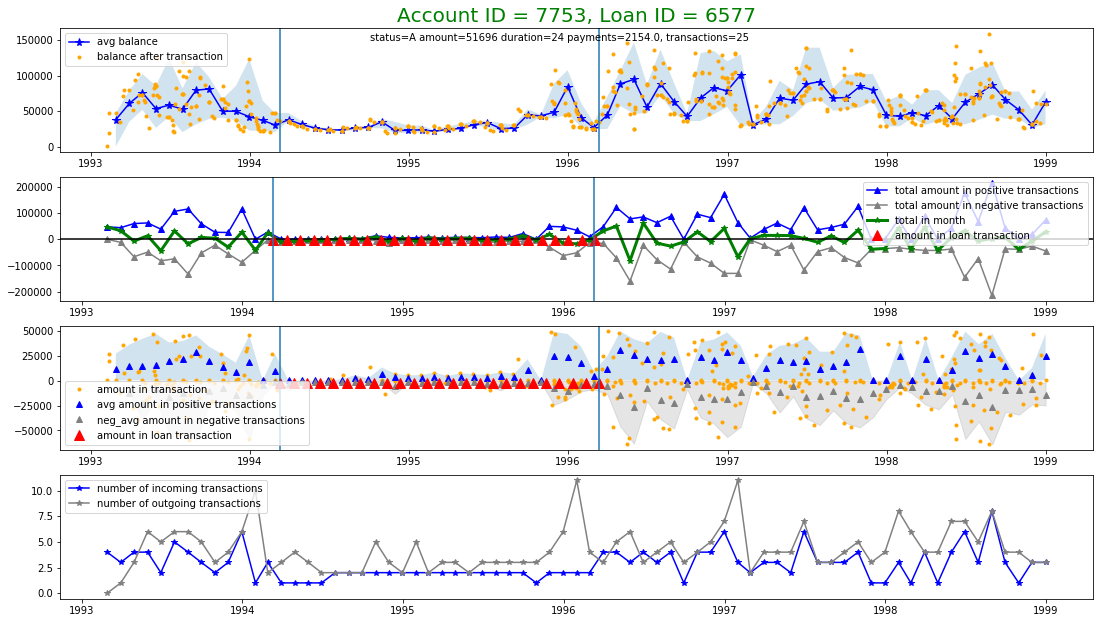

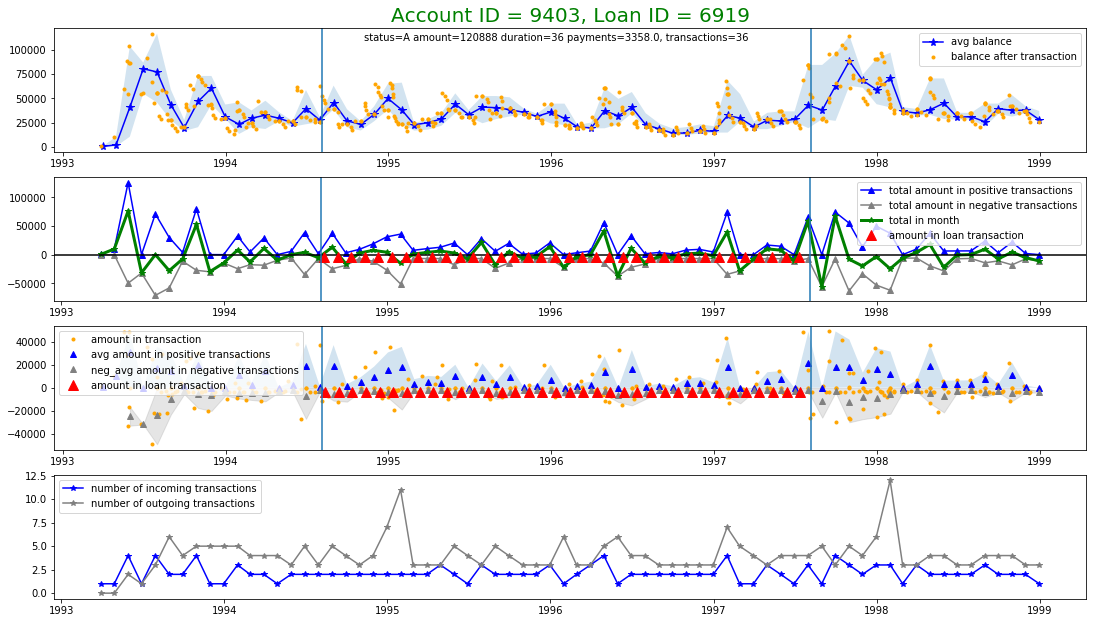

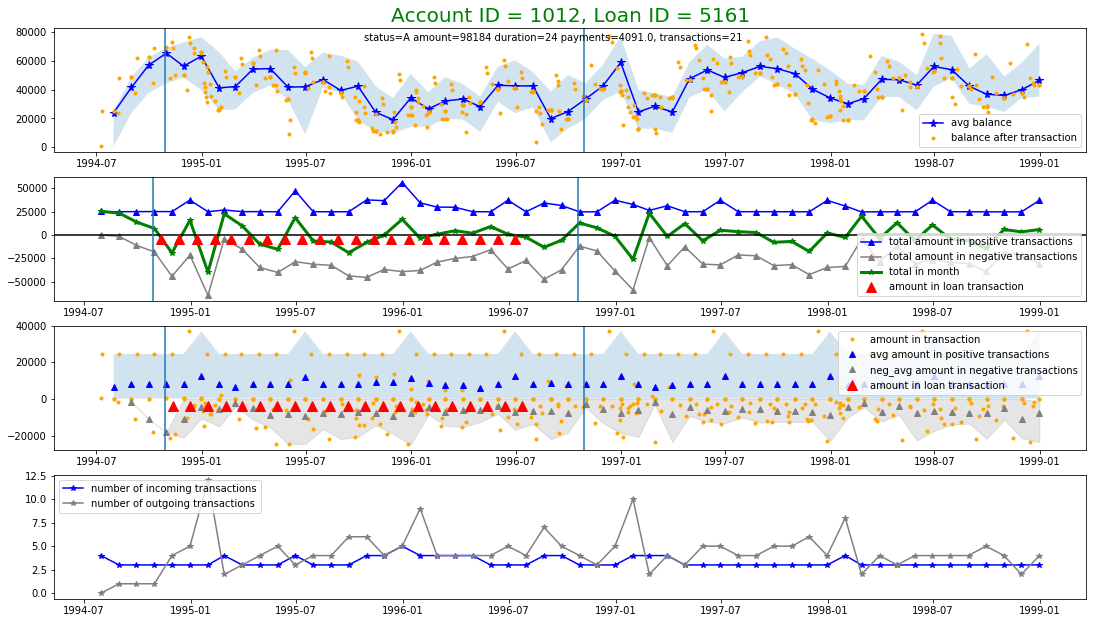

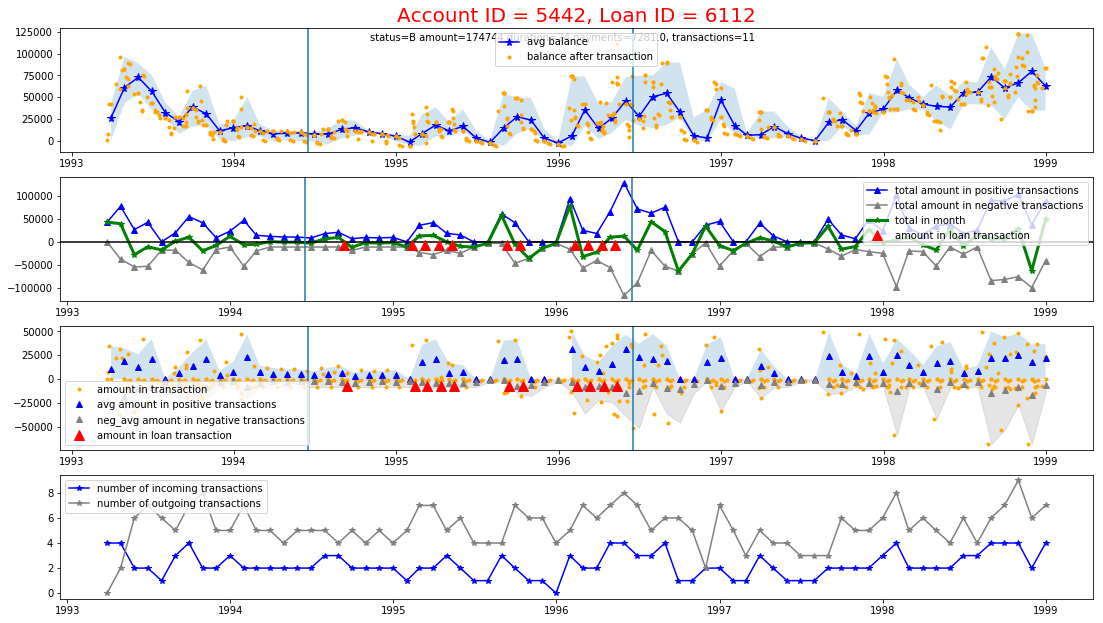

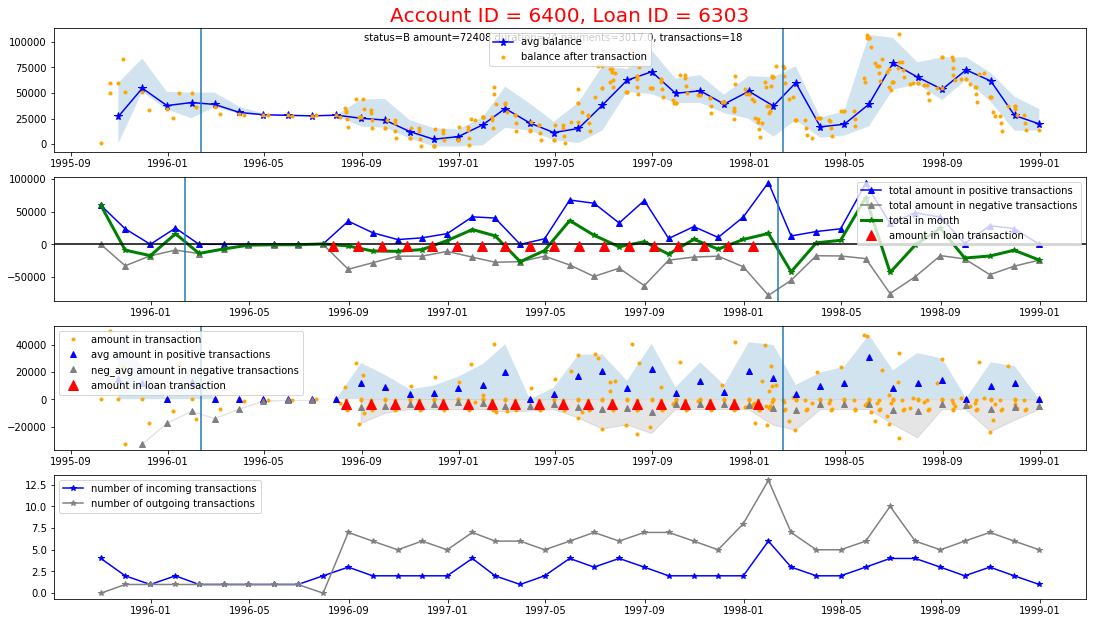

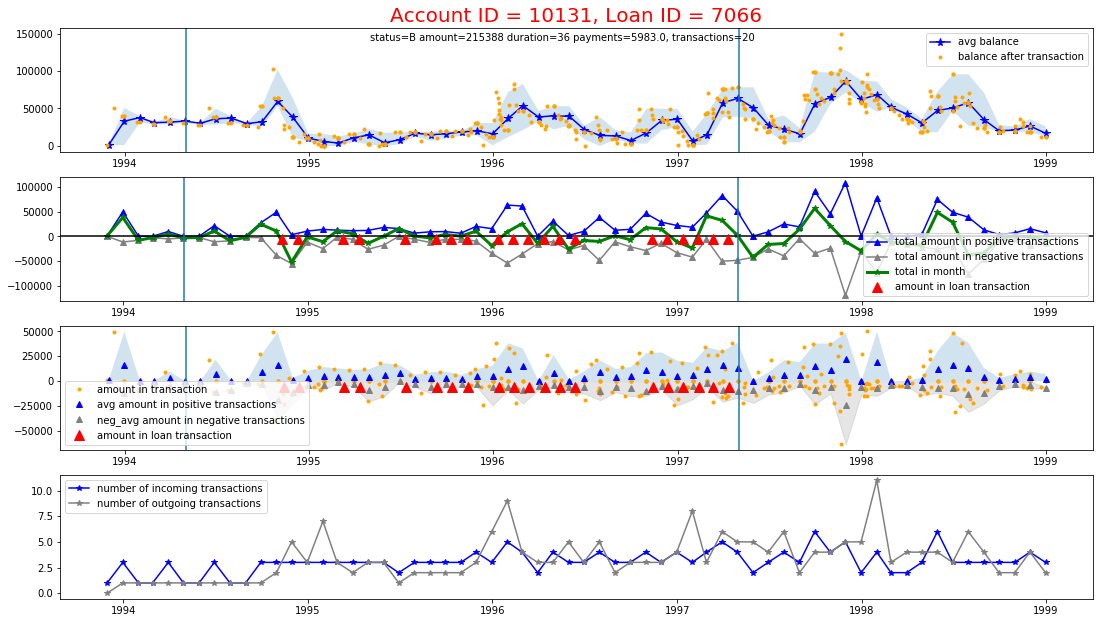

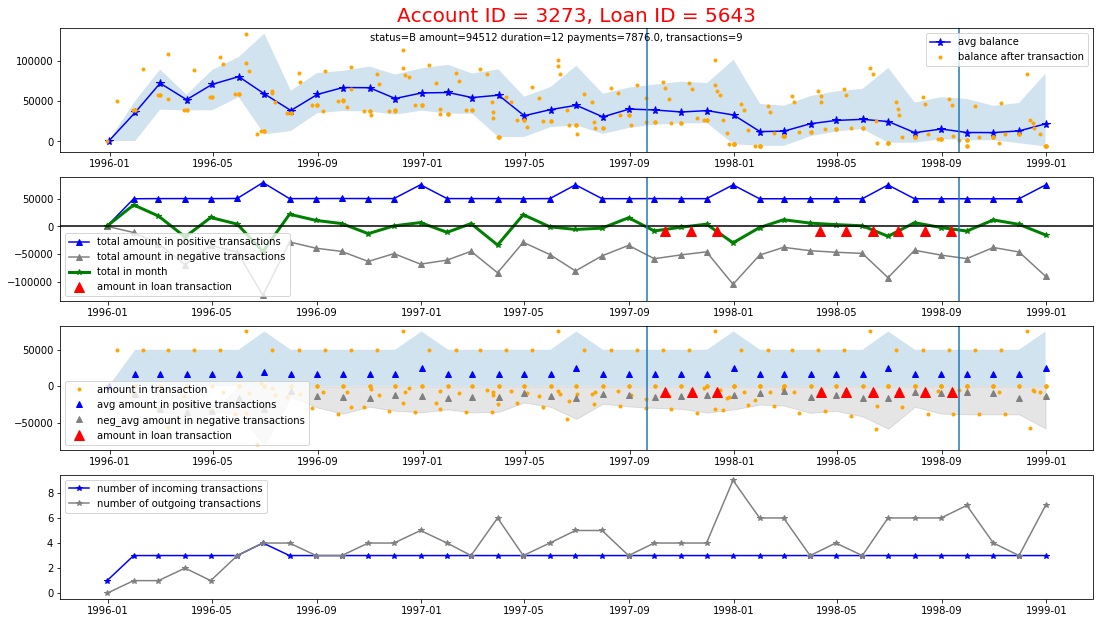

In [8]:
cts.plot_averages(trans2,loan, 7753)
cts.plot_averages(trans2,loan, 9403)
cts.plot_averages(trans2,loan, 1012)

cts.plot_averages(trans2,loan, 5442)
cts.plot_averages(trans2,loan, 6400)
cts.plot_averages(trans2,loan, 10131)
cts.plot_averages(trans2,loan, 3273)

The following plots show the average and minimun balance per month for all costumers with loans. Different color is used to identify successful loans and customers that had problems to fulfill all the payments. The monthly aggregated information can be recomputed with the script *compute_transac_stats.py*. 

The script *combine_transstats_client.py* combine (for the customers that have a loan) the client information with the montly stats values using the the loan starting date as new reference. 

In [17]:
with open("proc_data/data_transactions_monthlyagregated_all.pkl", 'rb') as fopen:
    dagr = pickle.load(fopen, encoding='latin1')   
with open("proc_data/client_info_extended_60m.pkl", "rb") as fopen:
    client_wl_info_60f = pickle.load(fopen, encoding='latin1')
with open("proc_data/client_info_extended_20mb.pkl", "rb") as fopen:
    client_wl_info_20b = pickle.load(fopen, encoding='latin1')


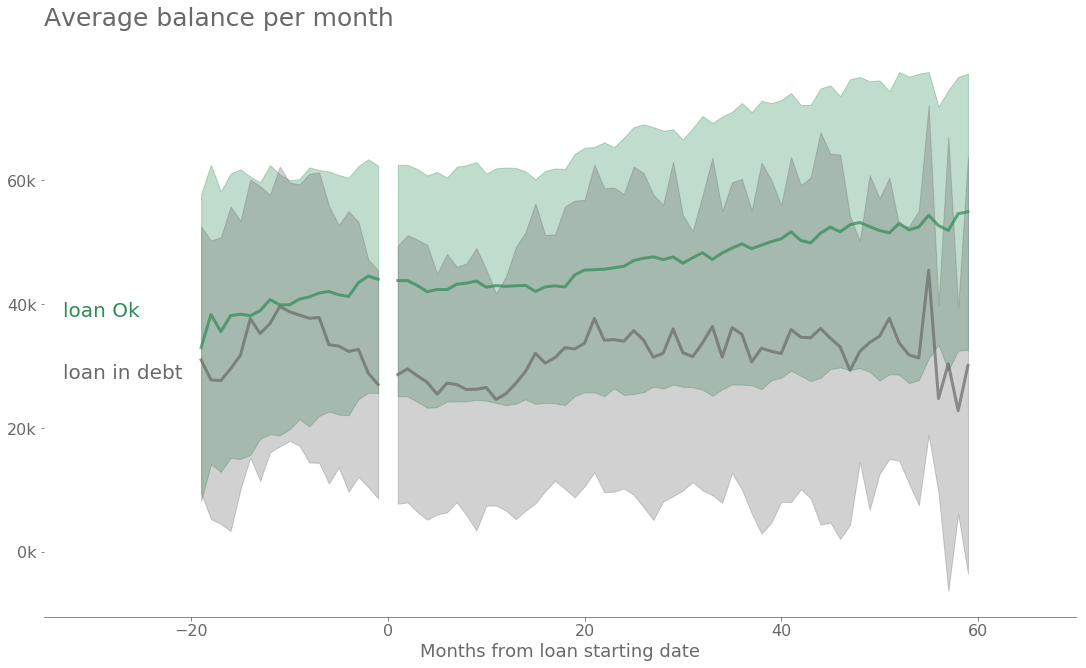

In [18]:
import plot_berka_p3 as pb
import imp
imp.reload(pb)
from matplotlib.ticker import FuncFormatter
fig,ax = plt.subplots(1,1)
fig.set_size_inches(18.5, 10.5, forward=True)

#for _id in _loan[(_loan.status == "A")].account_id.unique():
    #pb.plot_todateloan(dagr, _loan, _id, color="seagreen", ax=ax, alpha=0.01, keytoplot="balance")

#for _id in _loan[(_loan.status == "B")].account_id.unique():
    #pb.plot_todateloan(dagr, _loan, _id, color="brown", ax=ax, alpha = 0.01, keytoplot="balance")    

color2= "dimgray"
color1= "seagreen"
#ax.axvline(x=0, color="darkgrey")
ax.set_xlim([-35, 70])
ax.text(-33, 38000, "loan Ok",fontsize=20, color=color1)
ax.text(-33, 28000, "loan in debt",fontsize=20, color=color2)
pb.plot_fromloan(data=client_wl_info_60f, window=60, direction=1, param="balance_avg",ax=ax,
                 put_legend=False,color1=color1,color2=color2, plotminmax=False)
pb.plot_fromloan(data=client_wl_info_20b,window=20,ax=ax, put_legend=False, color1=color1,color2=color2,
                plotminmax=False)
aux = ax.set_title("Average balance per month", size=25,fontdict={"fontsize":30}, loc="left", pad=20, color="dimgray")
ax.set_xlabel("Months from loan starting date", fontsize=18, color="dimgray")
#config colors
ax.spines['bottom'].set_color('dimgray')
ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='x', colors='dimgray')
ax.tick_params(axis='y', colors='dimgray')

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(16)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(16) 
 

def kilos(x,pos):
    return '%1.0fk' % (x*1e-3)
formatter = FuncFormatter(kilos)
ax.yaxis.set_major_formatter(formatter)
ax.get_yaxis().set_ticks(np.arange(0,80000,20000))

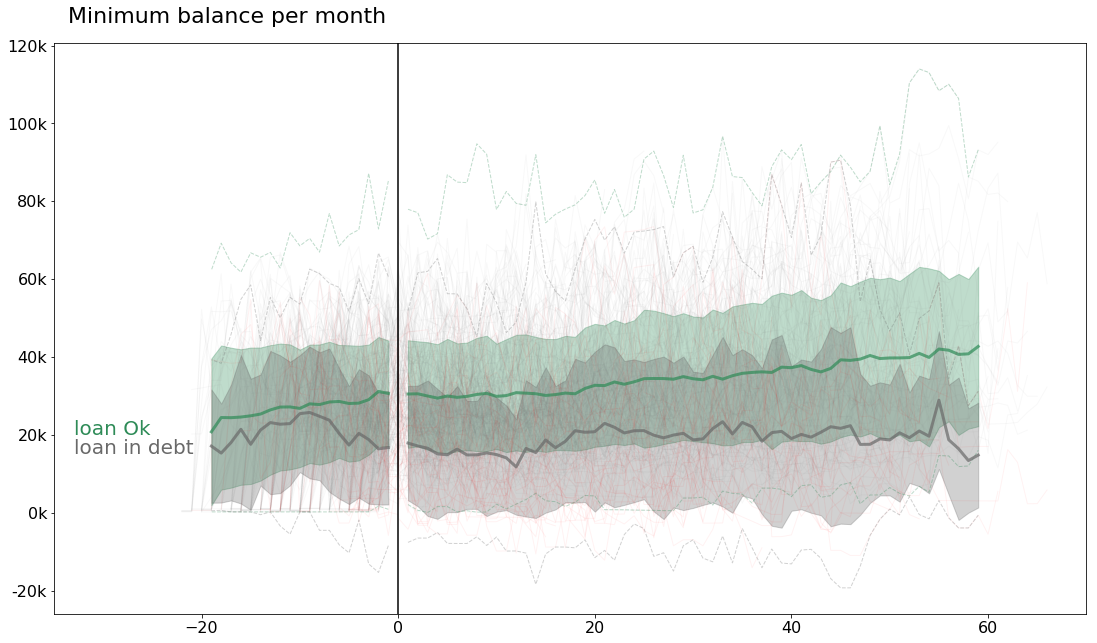

In [23]:
fig,ax = plt.subplots(1,1)
fig.set_size_inches(18.5, 10.5, forward=True)

for _id in loan[(loan.status == "A")].account_id.unique():
    pb.plot_todateloan(dagr, loan, _id, color="gray", ax=ax, alpha=0.05, keytoplot="balance_min")

for _id in loan[(loan.status == "B")].account_id.unique():
    pb.plot_todateloan(dagr, loan, _id, color="r", ax=ax, alpha = 0.05, keytoplot="balance_min")    
    
ax.axvline(x=0, color="black")  
ax.set_xlim([-35, 70])
#ax.text(-3, -20000, "loan starting date",fontsize=12)
ax.text(-33, 20000, "loan Ok",fontsize=20, color=color1)
ax.text(-33, 15000, "loan in debt",fontsize=20, color=color2)

pb.plot_fromloan(data=client_wl_info_60f, window=60, direction=1, param="balance_min",ax=ax,put_legend=False,
                color1=color1, color2=color2)
pb.plot_fromloan(data=client_wl_info_20b,window=20,ax=ax, param="balance_min", put_legend=False,
                color1=color1,color2=color2)
aux = ax.set_title("  Minimum balance per month", fontdict={"fontsize":22}, loc="left", pad=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(16)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(16) 
formatter = FuncFormatter(kilos)
ax.yaxis.set_major_formatter(formatter)

The monthly averages file is provided in the repo. It desired it can be recalculated with the script *compute_transac_stats.py*. to combine the monthly averaged data from transactions with the client data  use the scripts *combine_transstats_client.py*. The data is stored in proc_data/client_info_extended.pkl
The previous plot show the average balance and standard deviation for the costumers in the months before and after the loan was granted, 0 correspond to the loan start date. Is is shown how the distributions overlap although the averages differ. In order to forecast the loan future status only the information before the date of shall be use. It is interesting to note the difference between successful and faulty loans in the previous months. 

In [29]:
# Read client_info_extended.pkl (generated with combine_transstats_client.py)
# Extract new features (age, loan payment per month, number of client with access to account)
with open("proc_data/client_info_extended_20mb.pkl", "rb") as fopen:
    client_wl_info2 = pickle.load(fopen, encoding="latin1")

data = client_wl_info2
# for pos and neg transaction fill unknown values of with 0
for _k in ["pos_amount_max", "pos_amount_min", "pos_amount_avg", "pos_count",
          "neg_amount_avg", "neg_amount_max", "neg_amount_min", "neg_count"]:
    for _i in range(1,7,1):
        data["{0}_{1}mb".format(_k,_i)].fillna(value=0,inplace=True)

Select the parameters for prediction
==============================

In [26]:
#Import modules
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.svm import SVC,LinearSVC
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve, validation_curve


logd = LogisticRegression()
gnbc = GaussianNB()
rfc = RandomForestClassifier(n_estimators=500,
                             max_depth=5,criterion='gini',min_samples_split=3, min_samples_leaf=3,max_leaf_nodes=20)
etc = ExtraTreesClassifier(n_estimators=500,max_depth=5,
                           criterion='gini',min_samples_split=3, min_samples_leaf=3,max_leaf_nodes=20)#max_leaf_nodes=20)
nnc = KNeighborsClassifier(n_neighbors=15)
mlp = MLPClassifier(alpha=1)
adc = AdaBoostClassifier()
svc = SVC(C=0.7, kernel='rbf')
gpc = GaussianProcessClassifier(1.0 * RBF(1.0))
gbc = GradientBoostingClassifier()


In [49]:
# select the features for prediction
useinfomonths = 3
trans_features = ["pos_amount_max", "pos_amount_min", "pos_amount_avg", "pos_count",
        "neg_amount_avg", "neg_amount_max", "neg_amount_min", "neg_count",
        "balance_avg", "balance_min", "balance_max"]
features = []
for _k in trans_features:
    for _i in range(1,useinfomonths+1,1):
        features.append("{0}_{1}mb".format(_k,_i))
    
other_features = ["age", "gender", "A11", "A12", "A13", "A14", "A15", "A16"]
other_features = ["age", "gender", "A4", "A5", "A6", "A7","A11", "A13", "A14", "A16","has_card","permonth","amount","ndisp"]
features.extend(other_features)
X = data[features]
print ("Features used for prediction")
print (">>>>>>>>")
print (features)

#Use simple prediction all loans are good -> .89 accuracy
print ("<<<<<<<<\n")
print ("{0} faulty of {1}".format((client_wl_info2.status2 == 1).sum(), len(client_wl_info2)))
print ("If predict all as good loans the accuracy is: \n>>>>>>>",   round(
    (client_wl_info2.status2 == 0).sum()/float(len(client_wl_info2)),3))

dataf = data[features].copy()
dataf["class"] = data["status2"]
dataf.to_csv("proc_data/data_loans.csv")

#scale
scaler = StandardScaler()
scaler.fit(X)
X2 = scaler.transform(X)
y = data["status2"]

kf = KFold(n_splits=4, shuffle=True)
kf.get_n_splits(X2)
kfold = StratifiedKFold(n_splits=10)

Features used for prediction
>>>>>>>>
['pos_amount_max_1mb', 'pos_amount_max_2mb', 'pos_amount_max_3mb', 'pos_amount_min_1mb', 'pos_amount_min_2mb', 'pos_amount_min_3mb', 'pos_amount_avg_1mb', 'pos_amount_avg_2mb', 'pos_amount_avg_3mb', 'pos_count_1mb', 'pos_count_2mb', 'pos_count_3mb', 'neg_amount_avg_1mb', 'neg_amount_avg_2mb', 'neg_amount_avg_3mb', 'neg_amount_max_1mb', 'neg_amount_max_2mb', 'neg_amount_max_3mb', 'neg_amount_min_1mb', 'neg_amount_min_2mb', 'neg_amount_min_3mb', 'neg_count_1mb', 'neg_count_2mb', 'neg_count_3mb', 'balance_avg_1mb', 'balance_avg_2mb', 'balance_avg_3mb', 'balance_min_1mb', 'balance_min_2mb', 'balance_min_3mb', 'balance_max_1mb', 'balance_max_2mb', 'balance_max_3mb', 'age', 'gender', 'A4', 'A5', 'A6', 'A7', 'A11', 'A13', 'A14', 'A16', 'has_card', 'permonth', 'amount', 'ndisp']
<<<<<<<<

76 faulty of 682
If predict all as good loans the accuracy is: 
>>>>>>> 0.889


/home/dch/anaconda3/envs/ML3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/dch/anaconda3/envs/ML3/lib/python3.6/site-packages/ipykernel_launcher.py:32: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


In [60]:
len(features)

47

First use simple classifiers
======================

number of element in train sample =  [245 306 367 429 490 551 613]


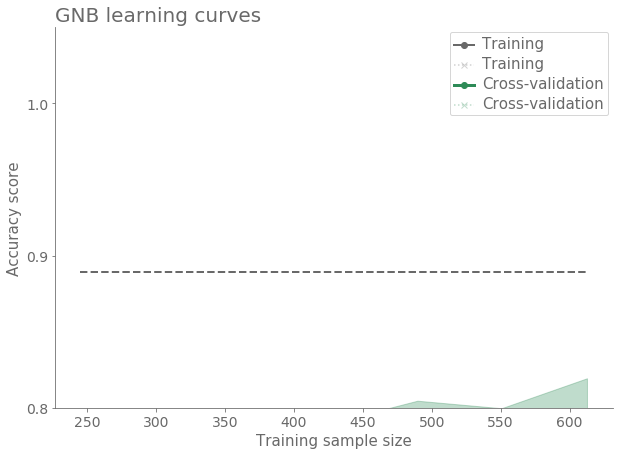

In [31]:
gnb = GaussianNB()
g = pb.plot_learning_curve(gnb,"GNB learning curves",X2,data["status2"],
                        cv=kfold,train_sizes=np.linspace(.4, 1.0, 7),color2="dimgrey",color1="seagreen")

number of element in train sample =  [183 255 326 398 469 541 613]


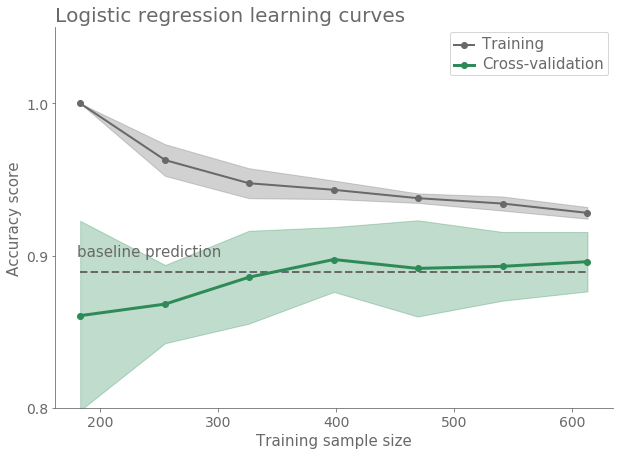

In [50]:
imp.reload(pb)

logc = LogisticRegression() #class_weight="balanced")
g = pb.plot_learning_curve(logc,"Logistic regression learning curves",X,data["status2"],cv=kfold,
                        train_sizes=np.linspace(.3, 1.0, 7),color2="dimgrey",color1="seagreen",plotmedian=False,
                          includebasetext=True )

number of element in train sample =  [ 61 199 337 475 613]


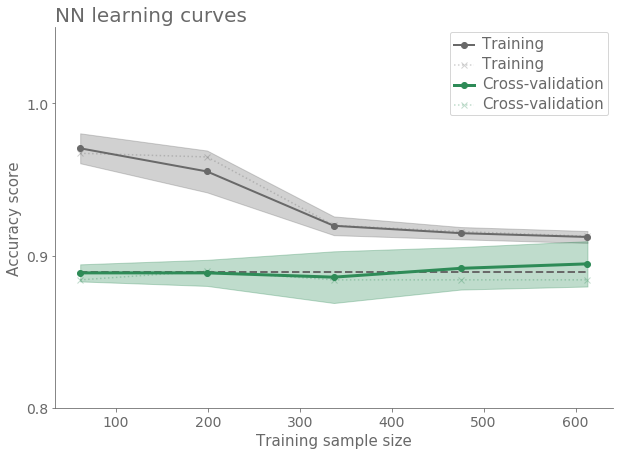

In [51]:
nnc = KNeighborsClassifier(n_neighbors=5)
g = pb.plot_learning_curve(nnc,"NN learning curves",X2,data["status2"],cv=kfold,color2="dimgrey",color1="seagreen")

Classifiers based on decision trees
===================================

number of element in train sample =  [ 61 199 337 475 613]


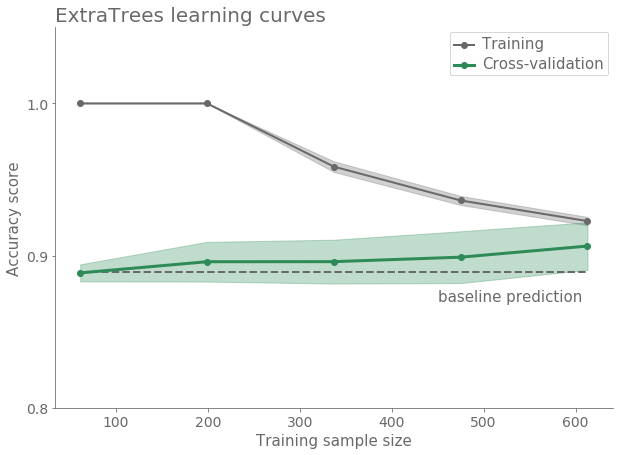

In [34]:
etc = ExtraTreesClassifier(**{'bootstrap': False, 
                              'min_samples_leaf': 1, 'n_estimators': 200, 
                              'min_samples_split': 2, 'criterion': 'gini', 'max_features': 5, 'max_depth': 7,
                              'max_leaf_nodes' : 25, 'random_state':57})
g = pb.plot_learning_curve(etc,"ExtraTrees learning curves",X2,data["status2"],cv=kfold,color2="dimgrey",
                           plotmedian=False,color1="seagreen",
                          includebasetext=True,baselinepos = [450,0.87])

number of element in train sample =  [ 61 199 337 475 613]


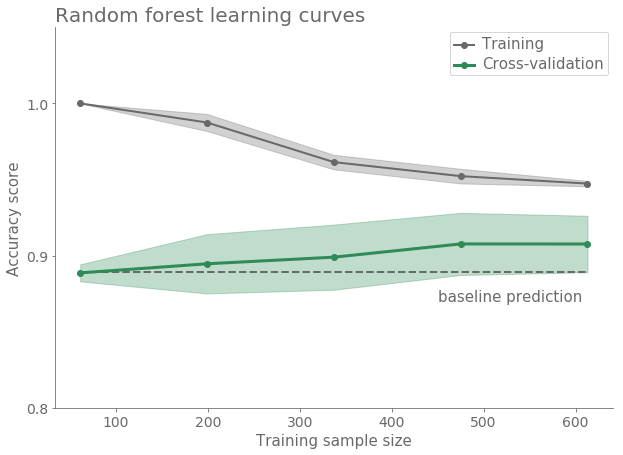

In [35]:
rfc = RandomForestClassifier(**{'bootstrap': False,
                              'min_samples_leaf': 3, 'n_estimators': 200,
                              'min_samples_split':3, 'criterion': 'gini',
                              'max_features': 5, 'max_depth': 6,'max_leaf_nodes':15, 'random_state':57})

g = pb.plot_learning_curve(rfc,"Random forest learning curves",X,data["status2"],
                           cv=kfold,color2="dimgrey",color1="seagreen", plotmedian=False,
                           includebasetext=True,baselinepos = [450,0.87])

number of element in train sample =  [ 61 199 337 475 613]


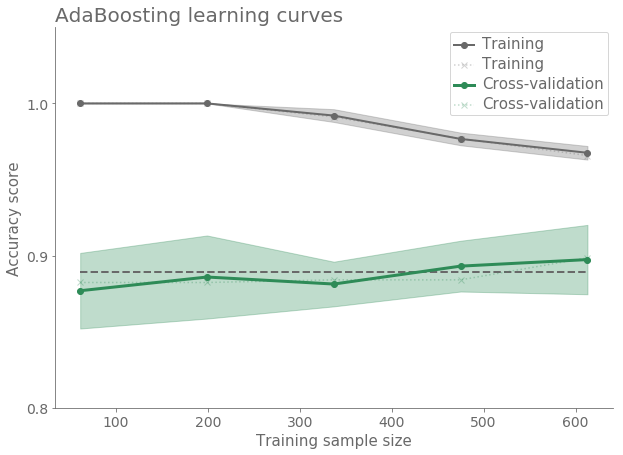

In [36]:
adc = AdaBoostClassifier(**{'n_estimators': 300, 'learning_rate': 0.1, 'algorithm': 'SAMME.R'})
g = pb.plot_learning_curve(adc,"AdaBoosting learning curves",X2,data["status2"],cv=kfold,color2="dimgrey",color1="seagreen")

number of element in train sample =  [183 291 398 505 613]


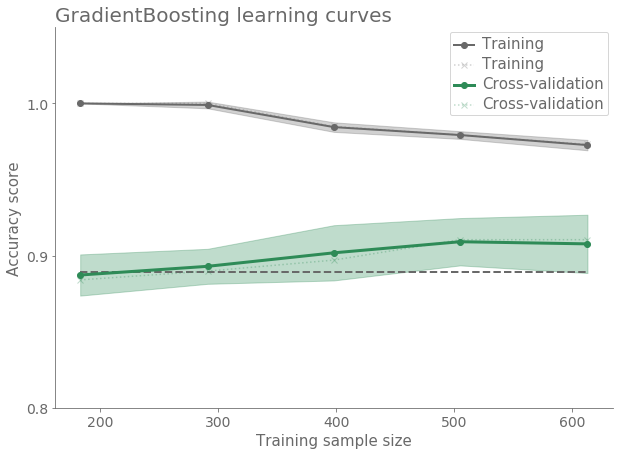

In [37]:
gbc = GradientBoostingClassifier(**{'loss': 'deviance', 'learning_rate': 0.02, 'min_samples_leaf': 20,
                            'n_estimators': 200, 'max_features': 7, 'max_depth': 5})
g = pb.plot_learning_curve(gbc,"GradientBoosting learning curves",X2,data["status2"],cv=kfold,
                           color2="dimgrey",color1="seagreen",
                        train_sizes=np.linspace(.3, 1.0, 5))

In [58]:
#Compute the estimation for different classifiers once the parameters are set
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import KFold
from sklearn import preprocessing
kf = KFold(n_splits=4, shuffle=True)
kf.get_n_splits(X2)
from sklearn.metrics import recall_score,accuracy_score,precision_score


rfc = RandomForestClassifier(**{'bootstrap': False,
                              'min_samples_leaf': 3, 'n_estimators': 200,
                              'min_samples_split':3, 'criterion': 'gini',
                              'max_features': 5, 'max_depth': 7,'max_leaf_nodes':20})
etc = ExtraTreesClassifier(**{'bootstrap': False, 
                              'min_samples_leaf': 1, 'n_estimators': 200, 
                              'min_samples_split': 2, 'criterion': 'gini', 'max_features': 5, 'max_depth': 7,
                              'max_leaf_nodes':25})
#mlp = MLPClassifier(alpha=1)
gnb = GaussianNB()
logc = LogisticRegression()
mlp=MLPClassifier(hidden_layer_sizes=200,alpha=0.05,max_iter=1000)
nnc = KNeighborsClassifier(n_neighbors=5)
adc = AdaBoostClassifier(**{'n_estimators':
                            300, 'learning_rate': 0.2, 'algorithm': 'SAMME.R'})
svc = SVC(probability=True,**{'kernel': 'rbf', 'C': 10, 'gamma': 0.0015})
lsvc = LinearSVC()


gbc = GradientBoostingClassifier(**{'loss': 'deviance', 'learning_rate': 0.02, 'min_samples_leaf': 30,
                            'n_estimators': 200, 'max_features': 9, 'max_depth': 5})

votingC_all = VotingClassifier(estimators=[('rfc', rfc), ('extc', etc),
                                       ('svc', svc) ,('gbc',gbc),('adc',adc),('mlp', mlp),#('gpc',gpc),
                                       ('nnc',nnc), ('gnb', gnb), ('logc',logc)], 
                               voting='soft', n_jobs=4)
votingC= VotingClassifier(estimators=[('rfc', rfc), ('extc', etc),
                                       ('svc', svc) ,('gbc',gbc),('adc',adc),#('logc',logc),#('gpc',gpc),
                                      ], voting='soft', n_jobs=4)

methods = [etc,svc,rfc,adc,gbc,mlp, nnc, gnb,logc, votingC,votingC_all]
checkmethods = ["etc","svc","rfc","adc","gbc","mlp","nnc", "gnb", "logc",
                "voting", "voting_all"]                       

_accu = {}
_accu_train = {}
_reca = {}
_prec = {}
_accu_simple = []
_lift = {}

for label in checkmethods:
    _accu[label] = []
    _accu_train[label] = []
    _reca[label] = []
    _prec[label] = []
    _lift[label] = []

itermax=2
for _i in range(itermax):
    kf = KFold(n_splits=4, shuffle=True)
    kf.get_n_splits(X2)
    #print "ite", _i+1
    for train_index, test_index in kf.split(X2):
        for useclass,label in zip(methods,checkmethods):
            classif_1 = useclass.fit(X2[train_index],data.iloc[train_index]["status2"])
            y_pred = classif_1.predict(X2[test_index])
            y_pred_train = classif_1.predict(X2[train_index])
            _accuracy = (y_pred == data.iloc[test_index]["status2"]).sum()/float(len(test_index))
            _accuracy2 = accuracy_score(data.iloc[test_index]["status2"], y_pred, normalize=True, sample_weight=None)
            _recall = recall_score(data.iloc[test_index]["status2"], y_pred)
            _precision = precision_score(data.iloc[test_index]["status2"], y_pred)
            _accuracy0 = (0 == data.iloc[test_index]["status2"]).sum()/float(len(test_index))
            _lift_aux = _accuracy/_accuracy0
            _accuracy_train = (y_pred_train == data.iloc[train_index]["status2"]).sum()/float(len(train_index))
            _accu[label].append(_accuracy)
            _accu_train[label].append(_accuracy_train)
            _reca[label].append(_recall)
            _prec[label].append(_precision)
            _lift[label].append(_lift_aux)

accuracy = pd.DataFrame.from_dict(_accu)
lift = pd.DataFrame.from_dict(_lift)
aux = accuracy.describe().T
auxl = lift.describe().T
print (aux.sort_values("mean",ascending=False)[["mean","std","min","max"]])
print (auxl.sort_values("mean",ascending=False)[["mean","std","min","max"]])

/home/dch/anaconda3/envs/ML3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dch/anaconda3/envs/ML3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dch/anaconda3/envs/ML3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dch/anaconda3/envs/ML3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dch/anaconda3/envs/ML3/lib/python3.6/site-packages/sklearn/linear_mo

                mean       std       min       max
voting_all  0.914947  0.018600  0.894118  0.941176
gbc         0.911300  0.022888  0.888235  0.952941
logc        0.906893  0.023508  0.871345  0.947368
rfc         0.906889  0.015830  0.888235  0.929825
voting      0.906884  0.020234  0.888235  0.941176
mlp         0.903221  0.020339  0.870588  0.929825
etc         0.902494  0.028522  0.853801  0.941176
adc         0.898826  0.023859  0.852941  0.923529
svc         0.898104  0.027115  0.859649  0.947059
nnc         0.898095  0.024678  0.865497  0.941176
gnb         0.728711  0.069800  0.576471  0.794118
                mean       std       min       max
voting_all  1.030291  0.025276  1.000000  1.083333
gbc         1.025962  0.018019  1.000000  1.055556
rfc         1.021200  0.021627  0.993711  1.062500
voting      1.021062  0.018881  1.006289  1.062500
logc        1.020955  0.016144  0.993711  1.034722
mlp         1.017013  0.023265  0.981132  1.048611
etc         1.015753  0.005060 

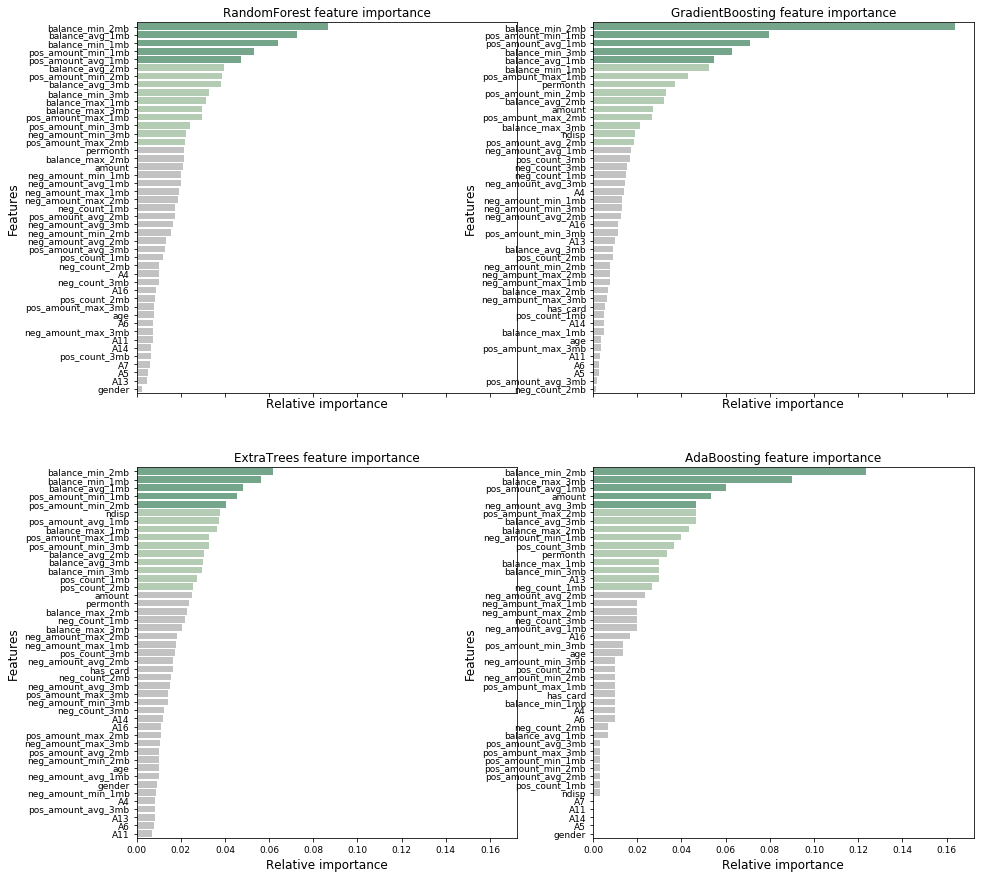

In [65]:
palette = ["seagreen"]*5
palette.extend(["darkseagreen"]*10)
palette.extend(["darkgrey"]*30)
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("RandomForest",rfc),("GradientBoosting",gbc),("ExtraTrees",etc),("AdaBoosting", adc)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:45]
        g = sns.barplot(y=np.array(features)[indices][:45],x = classifier.feature_importances_[indices][:45],
                        orient='h',ax=axes[row][col], palette=palette, alpha=0.7)
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

[]

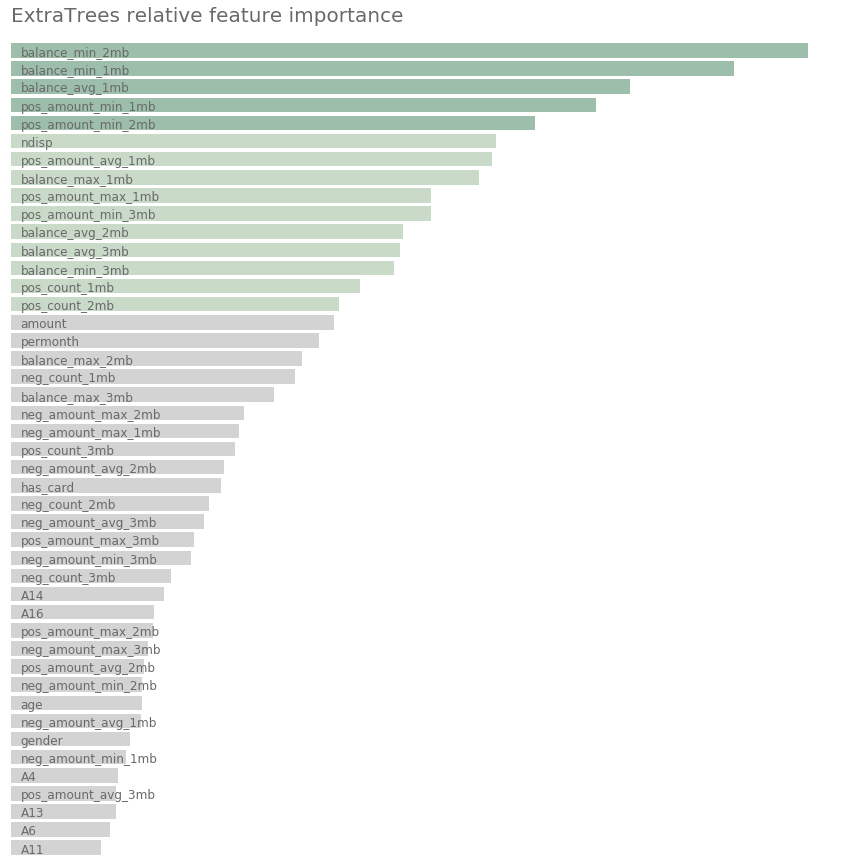

In [66]:
import ipdb
fig, axes = plt.subplots(1, 1, figsize=(15,15))

names_classifiers = [("RandomForest",rfc),("GradientBoosting",gbc),("ExtraTrees",etc),("AdaBoosting", adc)]

name = "ExtraTrees"
classifier = etc
indices = np.argsort(classifier.feature_importances_)[::-1][:45]
g = sns.barplot(y=np.array(features)[indices][:45],x = classifier.feature_importances_[indices][:45] , orient='h',
                ax=axes, palette=palette, alpha=0.5)

g.tick_params(labelsize=12)
g.set_title(name + " relative feature importance",loc="left",
                size=20, color="dimgray", pad=20)

axes.spines['bottom'].set_visible(False)
axes.spines['top'].set_visible(False) 
axes.spines['right'].set_visible(False)
axes.spines['left'].set_visible(False)
axes.tick_params(axis='x', colors='dimgray')
axes.tick_params(axis='y', colors='dimgray', size=3,left=False,right=False)
_labels = axes.get_yticklabels()
axes.set_yticklabels(_labels,horizontalalignment="left")
axes.tick_params(axis="y",direction="in", pad=-10, labelleft=True)
axes.get_xaxis().set_ticks([])

In [76]:
_labels

<a list of 40 Text yticklabel objects>

Looking at the plots it is clear that the balance in the months before the loan was granted add useful information for the classifiers. In all the cases the min balance 2 months before the loan is among the paramters which provide more information to the classifier.

Rank the probability of loan success
===============================

Some classifiers provide a probability for an item to be in one class. We can use this probabilities to sort the loans. In this exercice a Ramdon Forest classifier is used to rank the loans using the probability of being successful

In [180]:
rfc = RandomForestClassifier(**{'bootstrap': False,
                                  'min_samples_leaf': 3, 'n_estimators': 200,
                              'min_samples_split':3, 'criterion': 'gini',
                              'max_features': 5, 'max_depth': 7,'max_leaf_nodes':20})                    


kf = KFold(n_splits=4, shuffle=True)
kf.get_n_splits(X2)

perc = np.arange(0.1,1.03,0.05)
_ylift=[]
_yacc = []
rate_success = []
lift_success = []
for _i in range(len(perc)):
    _ylift.append([])
    _yacc.append([])
    rate_success.append([])
    lift_success.append([])
    
itermax=20
_acc0 = []
for _i in range(itermax):    
    for train_index, test_index in kf.split(X2):
        classif_1 = rfc.fit(X2[train_index],data.iloc[train_index]["status2"])
        y_pred = classif_1.predict(X2[test_index])
        y_pred_prob = classif_1.predict_proba(X2[test_index])
        _p_sorted = np.sort(y_pred_prob,axis=0)[::-1][:,0]
        _accuracy0 = (0 == data.iloc[test_index]["status2"]).sum()/float(len(y_pred))
        _acc0.append(_accuracy0)
        for _j in range(len(perc)):
            _p = perc[_j]
            pos = int(len(y_pred_prob)* _p) -1
            _val = _p_sorted[pos]
            _idx = (y_pred_prob[:,0] >= _val)
            _accuracy = ((y_pred == data.iloc[test_index]["status2"]) & _idx).sum()/float((_idx.sum()))
            perc_of_success = ((0 == data.iloc[test_index]["status2"]) & _idx).sum()/float((_idx.sum()))
            _lift_aux = _accuracy/_accuracy0
            _lift_success = perc_of_success / _accuracy0
            
            _ylift[_j].append(_lift_aux)
            lift_success[_j].append(_lift_success)
            _yacc[_j].append(_accuracy)
            rate_success[_j].append(perc_of_success)
            
meanacc = np.array([np.mean(e) for e in _yacc])
meanlift = np.array([np.mean(e) for e in _ylift])
stdacc = np.array([np.std(e) for e in _yacc])
stdlift = np.array([np.std(e) for e in _ylift])
meanperc_of_success = np.array([np.mean(e) for e in rate_success])
stdperc_of_success = np.array([np.std(e) for e in rate_success])
perc_of_success = np.array([np.mean(e) for e in rate_success])
stdperc_of_success = np.array([np.std(e) for e in rate_success])
lift_of_success = np.array([np.mean(e) for e in lift_success])
stdlift_of_success = np.array([np.std(e) for e in lift_success])

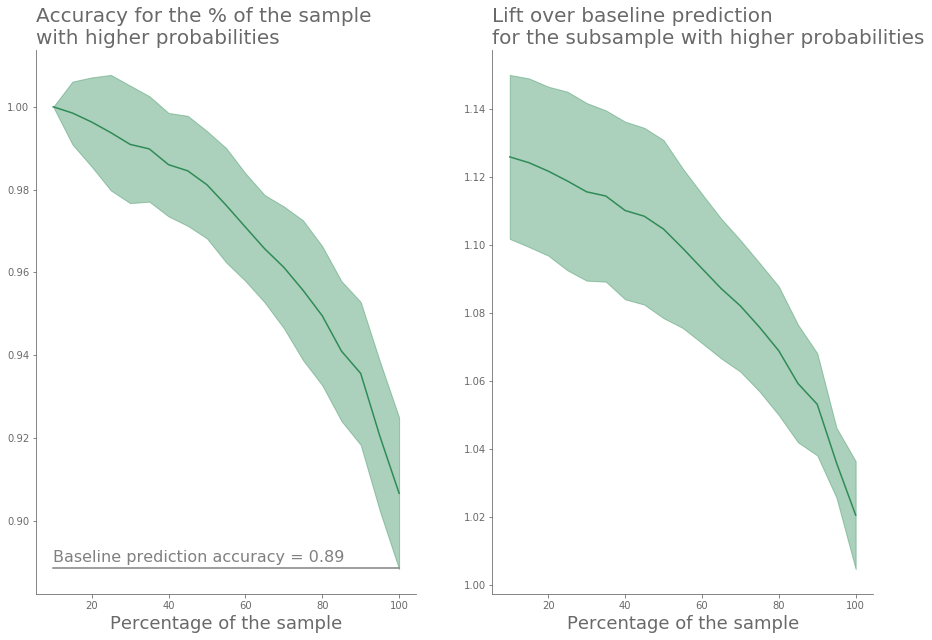

In [182]:
fig,ax = plt.subplots(1,2,figsize=(15, 10))

perc2=perc*100.
color="seagreen"
ax[0].plot(perc2,meanacc, color=color)

ax[0].fill_between(perc2,meanacc - stdacc, meanacc + stdacc, alpha=0.4,color=color)
ax[0].set_xlabel("Percentage of the sample",color="dimgray",size=18)
#ax[0].set_ylabel("accuracy")
acc0_mean = np.array(len(perc2)*[np.array(_acc0).mean()])
acc0_std = np.array(len(perc2)*[np.array(_acc0).std()])
_text = "Baseline prediction accuracy = {0}".format(round((data.status2 == 0).sum()/float(len(data)),2))
ax[0].plot(perc2,acc0_mean, color="gray")
ax[0].text(10, 0.89,_text, color="gray", size=16)
ax[1].plot(perc2,meanlift,color=color)
ax[1].fill_between(perc2, meanlift - stdlift, meanlift + stdlift, color=color,alpha=0.4)
ax[1].set_xlabel("Percentage of the sample", size=18,color="dimgray")
#ax[1].set_ylabel("lift")
ax[0].set_title("Accuracy for the % of the sample\nwith higher probabilities", loc="left",
                size=20, color="dimgray")
_aux=ax[1].set_title("Lift over baseline prediction\nfor the subsample with higher probabilities", loc="left",
                size=20, color="dimgray")


for i in [0,1]:
    ax[i].spines['bottom'].set_color('dimgray')
    ax[i].spines['top'].set_visible(False) 
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['left'].set_color('dimgray')
    ax[i].tick_params(axis='x', colors='dimgray')
    ax[i].tick_params(axis='y', colors='dimgray', size=3)

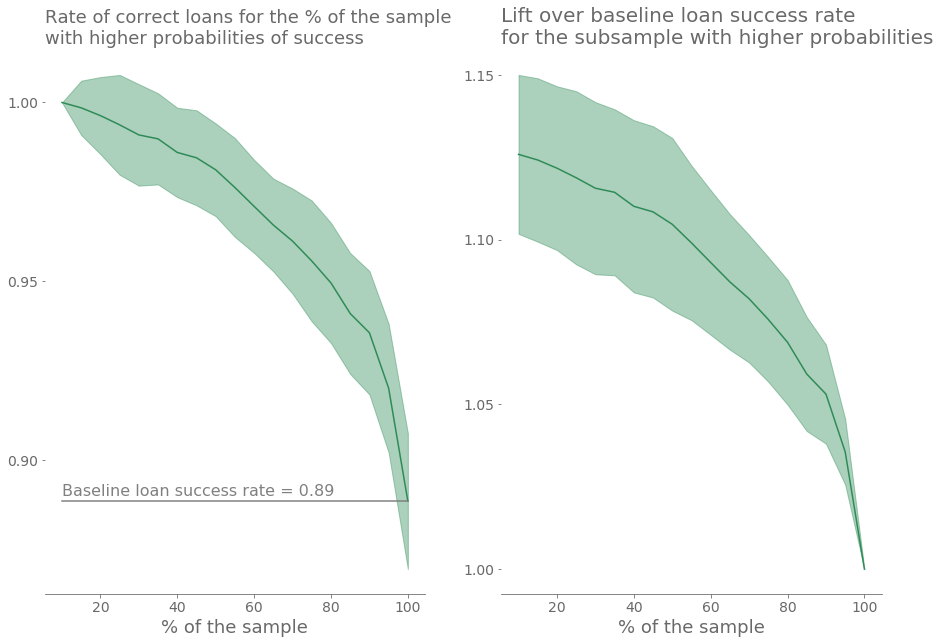

In [197]:
fig,ax = plt.subplots(1,2,figsize=(15, 10))

perc2=perc*100.
color="seagreen"
ax[0].plot(perc2,meanperc_of_success, color=color)
ax[0].fill_between(perc2, meanperc_of_success - stdperc_of_success,  meanperc_of_success + stdperc_of_success, alpha=0.4,color=color)
ax[0].set_xlabel("% of the sample",color="dimgray",size=18)
#ax[0].set_ylabel("accuracy")
acc0_mean = np.array(len(perc2)*[np.array(_acc0).mean()])
acc0_std = np.array(len(perc2)*[np.array(_acc0).std()])
_text = "Baseline loan success rate = {0}".format(round((data.status2 == 0).sum()/float(len(data)),2))
ax[0].plot(perc2,acc0_mean, color="gray")
ax[0].text(10, 0.89,_text, color="gray", size=16)
ax[1].plot(perc2,lift_of_success,color=color)
ax[1].fill_between(perc2,lift_of_success - stdlift_of_success, lift_of_success + stdlift_of_success, color=color,alpha=0.4)
ax[1].set_xlabel("% of the sample", size=18,color="dimgray")
#ax[1].set_ylabel("lift")
ax[0].set_title("Rate of correct loans for the % of the sample\nwith higher probabilities of success", loc="left",
                size=18, color="dimgray")
_aux=ax[1].set_title("Lift over baseline loan success rate\nfor the subsample with higher probabilities", loc="left",
                size=20, color="dimgray")


for i in [0,1]:
    ax[i].spines['bottom'].set_color('dimgray')
    ax[i].spines['top'].set_visible(False) 
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
    ax[i].tick_params(axis='x', colors='dimgray')
    ax[i].tick_params(axis='y', colors='dimgray', size=3)
    ax[i].tick_params(labelsize=14)

ax[0].get_yaxis().set_ticks(np.arange(0.9,1.01,0.05))
ax[1].get_yaxis().set_ticks(np.arange(1.0,1.16,0.05))

Details on faulty loans
=======================

[]

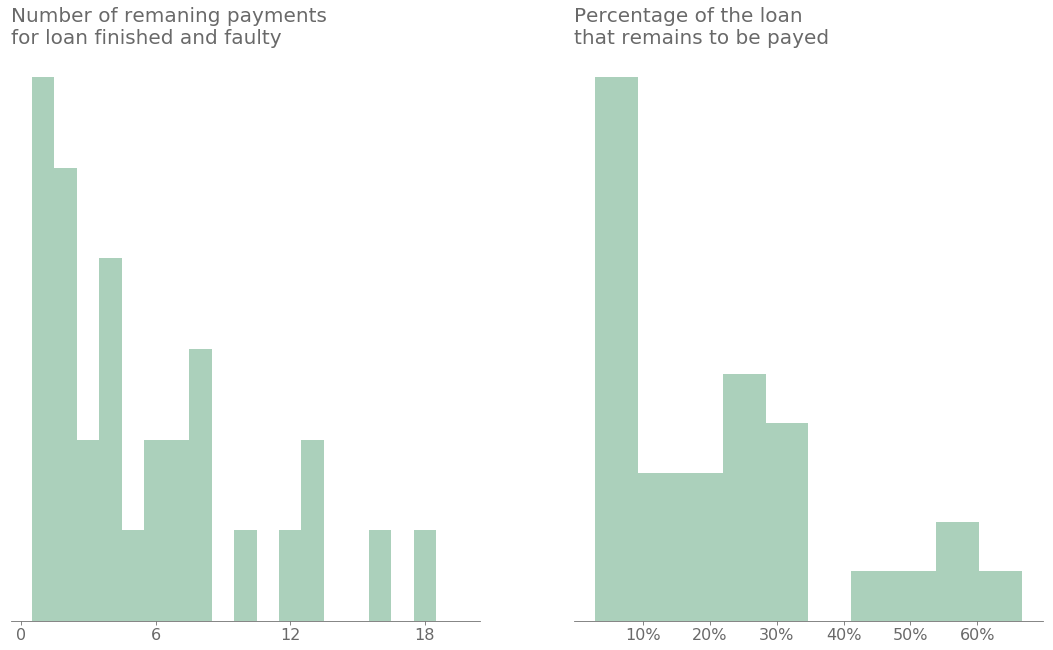

In [173]:
mask = (df_allinfo["status"]=="B")
fig,ax = plt.subplots(1,2)
hist1=ax[0].hist(df_allinfo[mask]["nloan_payments_remain"], bins=np.arange(0,20)+0.5,
                 color="seagreen", alpha=0.4)
ax[0].set_xticks(np.arange(0, 19, step=6))
fig.set_size_inches(18.5, 10.5, forward=True)
hist2=ax[1].hist(100.*df_allinfo[mask]["nloan_payments_remain"]/df_allinfo[mask]["duration"],
                 color=color, alpha=0.4)
ax[0].set_title("Number of remaning payments\nfor loan finished and faulty", loc="left",
                size=20, color="dimgray")
_aux=ax[1].set_title("Percentage of the loan\nthat remains to be payed", loc="left",
                size=20, color="dimgray")
#ax[0].set_ylabel("Number of costumers", size=18,color="dimgray")

for i in [0,1]:
    ax[i].spines['bottom'].set_color('dimgray')
    #ax[i].spines['bottom'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
    ax[i].tick_params(axis='x', colors='dimgray')
    ax[i].tick_params(axis='y', colors='dimgray', size=3)
    for tick in ax[i].xaxis.get_major_ticks():
        tick.label.set_fontsize(16)

    for tick in ax[i].yaxis.get_major_ticks():
        tick.label.set_fontsize(16) 

def perc(x,pos):
    return '{0:d}%'.format(int(x))
formatter = FuncFormatter(perc)
ax[1].xaxis.set_major_formatter(formatter)
ax[1].get_xaxis().set_ticks(np.arange(10,70,10))
ax[1].get_yaxis().set_ticks([])
ax[0].get_yaxis().set_ticks([])

Final remarks
=============

This study is a exercice to show the potential usage of transaction records to evaluate potential risk in loans. Hovewer the previous plots show that in this case almost all the customers pay on time the loan payments. Even in those loans marked as "not payed" the customer actually pay a very sustantial part of it, and in most of the cases their balances are in good shape to pay the remaning quantities.